In [1]:
# trace_skeleton.py
# Trace skeletonization result into polylines
#
# Lingdong Huang 2020

import numpy as np

# binary image thinning (skeletonization) in-place.
# implements Zhang-Suen algorithm.
# http://agcggs680.pbworks.com/f/Zhan-Suen_algorithm.pdf
# @param im   the binary image
def thinningZS(im):
    prev = np.zeros(im.shape,np.uint8);
    while True:
        im = thinningZSIteration(im,0);
        im = thinningZSIteration(im,1)
        diff = np.sum(np.abs(prev-im));
        if not diff:
            break
        prev = im
    return im

# 1 pass of Zhang-Suen thinning 
def thinningZSIteration(im, iter):
    marker = np.zeros(im.shape,np.uint8);
    for i in range(1,im.shape[0]-1):
        for j in range(1,im.shape[1]-1):
            p2 = im[(i-1),j]  ;
            p3 = im[(i-1),j+1];
            p4 = im[(i),j+1]  ;
            p5 = im[(i+1),j+1];
            p6 = im[(i+1),j]  ;
            p7 = im[(i+1),j-1];
            p8 = im[(i),j-1]  ;
            p9 = im[(i-1),j-1];
            A  = (p2 == 0 and p3) + (p3 == 0 and p4) + \
                 (p4 == 0 and p5) + (p5 == 0 and p6) + \
                 (p6 == 0 and p7) + (p7 == 0 and p8) + \
                 (p8 == 0 and p9) + (p9 == 0 and p2);
            B  = p2 + p3 + p4 + p5 + p6 + p7 + p8 + p9;
            m1 = (p2 * p4 * p6) if (iter == 0 ) else (p2 * p4 * p8);
            m2 = (p4 * p6 * p8) if (iter == 0 ) else (p2 * p6 * p8);

        if (A == 1 and (B >= 2 and B <= 6) and m1 == 0 and m2 == 0):
            marker[i,j] = 1;

    return np.bitwise_and(im,np.bitwise_not(marker))


def thinningSkimage(im):
    from skimage.morphology import skeletonize
    return skeletonize(im).astype(np.uint8)

def thinning(im):
    try:
        return thinningSkimage(im)
    except:
        return thinningZS(im)

#check if a region has any white pixel
def notEmpty(im, x, y, w, h):
  return np.sum(im) > 0


# merge ith fragment of second chunk to first chunk
# @param c0   fragments from first  chunk
# @param c1   fragments from second chunk
# @param i    index of the fragment in first chunk
# @param sx   (x or y) coordinate of the seam
# @param isv  is vertical, not horizontal?
# @param mode 2-bit flag, 
#             MSB = is matching the left (not right) end of the fragment from first  chunk
#             LSB = is matching the right (not left) end of the fragment from second chunk
# @return     matching successful?             
# 
def mergeImpl(c0, c1, i, sx, isv, mode):

  B0 = (mode >> 1 & 1)>0; # match c0 left
  B1 = (mode >> 0 & 1)>0; # match c1 left
  mj = -1;
  md = 4; # maximum offset to be regarded as continuous
  
  p1 = c1[i][0 if B1 else -1];
  
  if (abs(p1[isv]-sx)>0): # not on the seam, skip
    return False
  
  # find the best match
  for j in range(len(c0)):
    p0 = c0[j][0 if B0 else -1];
    if (abs(p0[isv]-sx)>1): # not on the seam, skip
      continue
    
    d = abs(p0[not isv] - p1[not isv]);
    if (d < md):
      mj = j;
      md = d;

  if (mj != -1): # best match is good enough, merge them
    if (B0 and B1):
      c0[mj] = list(reversed(c1[i])) + c0[mj]
    elif (not B0 and B1):
      c0[mj]+=c1[i]
    elif (B0 and not B1):
      c0[mj] = c1[i] + c0[mj]
    else:
      c0[mj] += list(reversed(c1[i]))
    
    c1.pop(i);
    return True;
  return False;

HORIZONTAL = 1;
VERTICAL = 2;

# merge fragments from two chunks
# @param c0   fragments from first  chunk
# @param c1   fragments from second chunk
# @param sx   (x or y) coordinate of the seam
# @param dr   merge direction, HORIZONTAL or VERTICAL?
# 
def mergeFrags(c0, c1, sx, dr):
  for i in range(len(c1)-1,-1,-1):
    if (dr == HORIZONTAL):
      if (mergeImpl(c0,c1,i,sx,False,1)):continue;
      if (mergeImpl(c0,c1,i,sx,False,3)):continue;
      if (mergeImpl(c0,c1,i,sx,False,0)):continue;
      if (mergeImpl(c0,c1,i,sx,False,2)):continue;
    else:
      if (mergeImpl(c0,c1,i,sx,True,1)):continue;
      if (mergeImpl(c0,c1,i,sx,True,3)):continue;
      if (mergeImpl(c0,c1,i,sx,True,0)):continue;
      if (mergeImpl(c0,c1,i,sx,True,2)):continue;      
    
  c0 += c1


# recursive bottom: turn chunk into polyline fragments;
# look around on 4 edges of the chunk, and identify the "outgoing" pixels;
# add segments connecting these pixels to center of chunk;
# apply heuristics to adjust center of chunk
# 
# @param im   the bitmap image
# @param x    left of   chunk
# @param y    top of    chunk
# @param w    width of  chunk
# @param h    height of chunk
# @return     the polyline fragments
# 
def chunkToFrags(im, x, y, w, h):
  frags = []
  on = False; # to deal with strokes thicker than 1px
  li=-1; lj=-1;
  
  # walk around the edge clockwise
  for k in range(h+h+w+w-4):
    i=0; j=0;
    if (k < w):
      i = y+0; j = x+k;
    elif (k < w+h-1):
      i = y+k-w+1; j = x+w-1;
    elif (k < w+h+w-2):
      i = y+h-1; j = x+w-(k-w-h+3); 
    else:
      i = y+h-(k-w-h-w+4); j = x+0;
    
    if (im[i,j]): # found an outgoing pixel
      if (not on):     # left side of stroke
        on = True;
        frags.append([[j,i],[x+w//2,y+h//2]])
    else:
      if (on):# right side of stroke, average to get center of stroke
        frags[-1][0][0]= (frags[-1][0][0]+lj)//2;
        frags[-1][0][1]= (frags[-1][0][1]+li)//2;
        on = False;
    li = i;
    lj = j;
  
  if (len(frags) == 2): # probably just a line, connect them
    f = [frags[0][0],frags[1][0]];
    frags.pop(0);
    frags.pop(0);
    frags.append(f);
  elif (len(frags) > 2): # it's a crossroad, guess the intersection
    ms = 0;
    mi = -1;
    mj = -1;
    # use convolution to find brightest blob
    for i in range(y+1,y+h-1):
      for j in range(x+1,x+w-1):
        s = \
          (im[i-1,j-1]) + (im[i-1,j]) +(im[i-1,j+1])+\
          (im[i,j-1]  ) +   (im[i,j]) +    (im[i,j+1])+\
          (im[i+1,j-1]) + (im[i+1,j]) +  (im[i+1,j+1]);
        if (s > ms):
          mi = i;
          mj = j;
          ms = s;
        elif (s == ms and abs(j-(x+w//2))+abs(i-(y+h//2)) < abs(mj-(x+w//2))+abs(mi-(y+h//2))):
          mi = i;
          mj = j;
          ms = s;

    if (mi != -1):
      for i in range(len(frags)):
        frags[i][1]=[mj,mi]
  return frags;


# Trace skeleton from thinning result.
# Algorithm:
# 1. if chunk size is small enough, reach recursive bottom and turn it into segments
# 2. attempt to split the chunk into 2 smaller chunks, either horizontall or vertically;
#    find the best "seam" to carve along, and avoid possible degenerate cases
# 3. recurse on each chunk, and merge their segments
# 
# @param im      the bitmap image
# @param x       left of   chunk
# @param y       top of    chunk
# @param w       width of  chunk
# @param h       height of chunk
# @param csize   chunk size
# @param maxIter maximum number of iterations
# @param rects   if not null, will be populated with chunk bounding boxes (e.g. for visualization)
# @return        an array of polylines
# 
def traceSkeleton(im, x, y, w, h, csize, maxIter, rects):
  
  frags = []
  
  if (maxIter == 0): # gameover
    return frags;
  if (w <= csize and h <= csize): # recursive bottom
    frags += chunkToFrags(im,x,y,w,h);
    return frags;
  
  ms = im.shape[0]+im.shape[1]; # number of white pixels on the seam, less the better
  mi = -1; # horizontal seam candidate
  mj = -1; # vertical   seam candidate
  
  if (h > csize): # try splitting top and bottom
    for i in range(y+3,y+h-3):
      if (im[i,x]  or im[(i-1),x]  or im[i,x+w-1]  or im[(i-1),x+w-1]):
        continue
      
      s = 0;
      for j in range(x,x+w):
        s += im[i,j];
        s += im[(i-1),j];
      
      if (s < ms):
        ms = s; mi = i;
      elif (s == ms  and  abs(i-(y+h//2))<abs(mi-(y+h//2))):
        # if there is a draw (very common), we want the seam to be near the middle
        # to balance the divide and conquer tree
        ms = s; mi = i;
  
  if (w > csize): # same as above, try splitting left and right
    for j in range(x+3,x+w-2):
      if (im[y,j] or im[(y+h-1),j] or im[y,j-1] or im[(y+h-1),j-1]):
        continue
      
      s = 0;
      for i in range(y,y+h):
        s += im[i,j];
        s += im[i,j-1];
      if (s < ms):
        ms = s;
        mi = -1; # horizontal seam is defeated
        mj = j;
      elif (s == ms  and  abs(j-(x+w//2))<abs(mj-(x+w//2))):
        ms = s;
        mi = -1;
        mj = j;

  nf = []; # new fragments
  if (h > csize  and  mi != -1): # split top and bottom
    L = [x,y,w,mi-y];    # new chunk bounding boxes
    R = [x,mi,w,y+h-mi];
    
    if (notEmpty(im,L[0],L[1],L[2],L[3])): # if there are no white pixels, don't waste time
      if(rects!=None):rects.append(L);
      nf += traceSkeleton(im,L[0],L[1],L[2],L[3],csize,maxIter-1,rects) # recurse
    
    if (notEmpty(im,R[0],R[1],R[2],R[3])):
      if(rects!=None):rects.append(R);
      mergeFrags(nf,traceSkeleton(im,R[0],R[1],R[2],R[3],csize,maxIter-1,rects),mi,VERTICAL);
    
  elif (w > csize  and  mj != -1): # split left and right
    L = [x,y,mj-x,h];
    R = [mj,y,x+w-mj,h];
    if (notEmpty(im,L[0],L[1],L[2],L[3])):
      if(rects!=None):rects.append(L);
      nf+=traceSkeleton(im,L[0],L[1],L[2],L[3],csize,maxIter-1,rects);
    
    if (notEmpty(im,R[0],R[1],R[2],R[3])):
      if(rects!=None):rects.append(R);
      mergeFrags(nf,traceSkeleton(im,R[0],R[1],R[2],R[3],csize,maxIter-1,rects),mj,HORIZONTAL);
    
  frags+=nf;
  if (mi == -1  and  mj == -1): # splitting failed! do the recursive bottom instead
    frags += chunkToFrags(im,x,y,w,h);
  
  return frags


if __name__ == "__main__":
  import cv2
  import random
  import imageio

  #im0 = cv2.imread("../test_images/opencv-thinning-src-img.png")
  #im0 = cv2.imread('/Users/yuqzhou/Downloads/DRIVE/training/1st_manual/22_manual1.gif')
  im0 = imageio.imread(
      '/home/alexey/programming/squanch_work/RetinalVesselSegmentation/third_patry/MedISeg/2DUNet/Experiment/EYEDataset_512/isic2018/baseline/res50/fold_0/test_results/submit/{}.png'.format(
      910  
    )
  )
  black_map = np.zeros((im0.shape[0],im0.shape[1],3)).astype(np.uint8)
  im = (im0[:,:]>128).astype(np.uint8)

  # for i in range(im.shape[0]):
  #   for j in range(im.shape[1]):
  #     print(im[i,j],end="")
  #   print("")
  # print(np.sum(im),im.shape[0]*im.shape[1])
  im = thinning(im);

  # cv2.imshow('',im*255);cv2.waitKey(0)

  rects = []
  polys = traceSkeleton(im,0,0,im.shape[1],im.shape[0],10,999,rects)
  
  

/tmp/ipykernel_49084/4029972327.py:314: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im0 = imageio.imread(


In [3]:
image_path = '/home/alexey/programming/squanch_work/RetinalVesselSegmentation/third_patry/MedISeg/2DUNet/Experiment/EYEDataset_512/isic2018/baseline/res50/fold_0/test_results/submit/{}.png'.format(
  910  
)

/tmp/ipykernel_49084/2920724732.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im0 = imageio.imread(image_path)  #input one example image in DRIVE


(-0.5, 1623.5, 1231.5, -0.5)

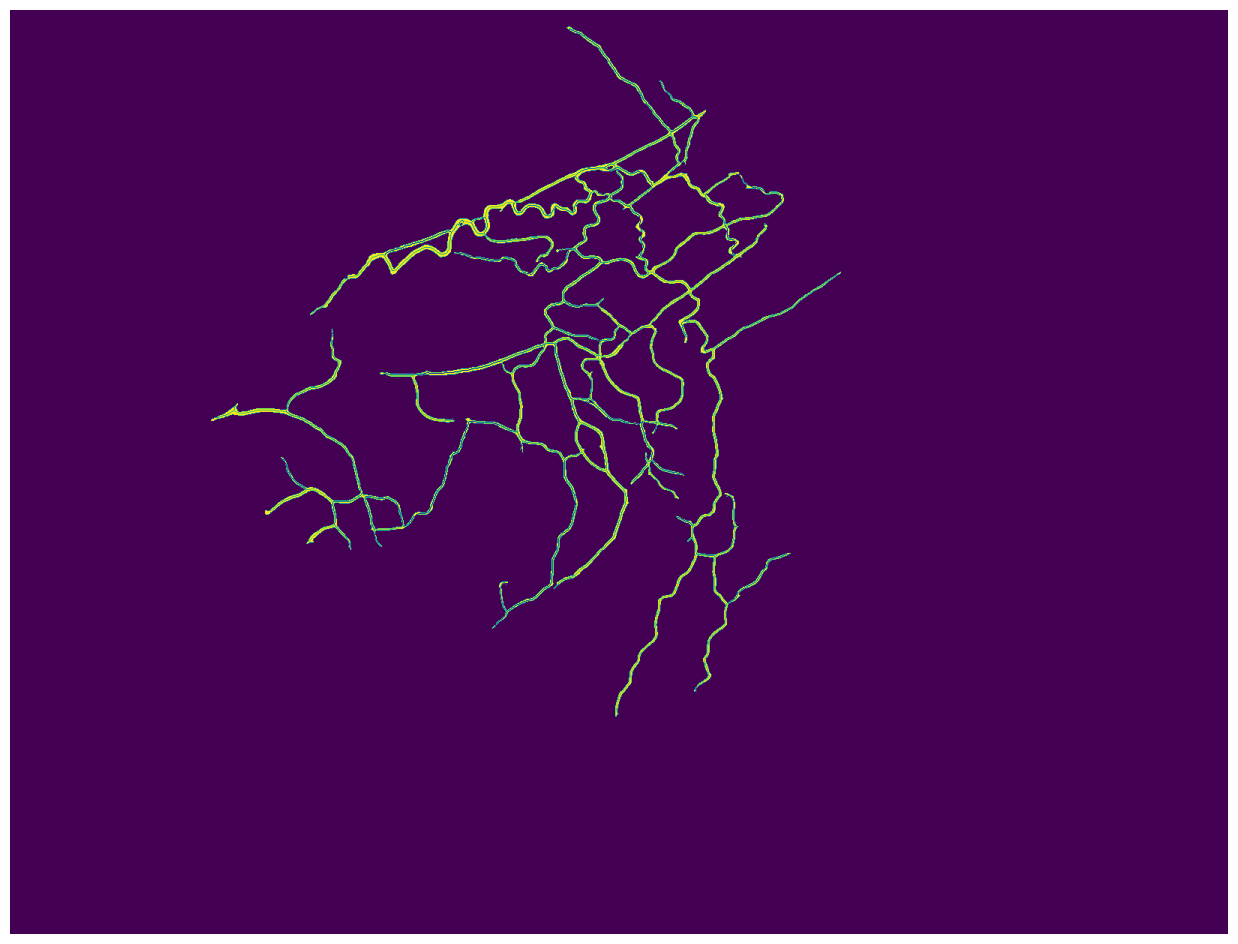

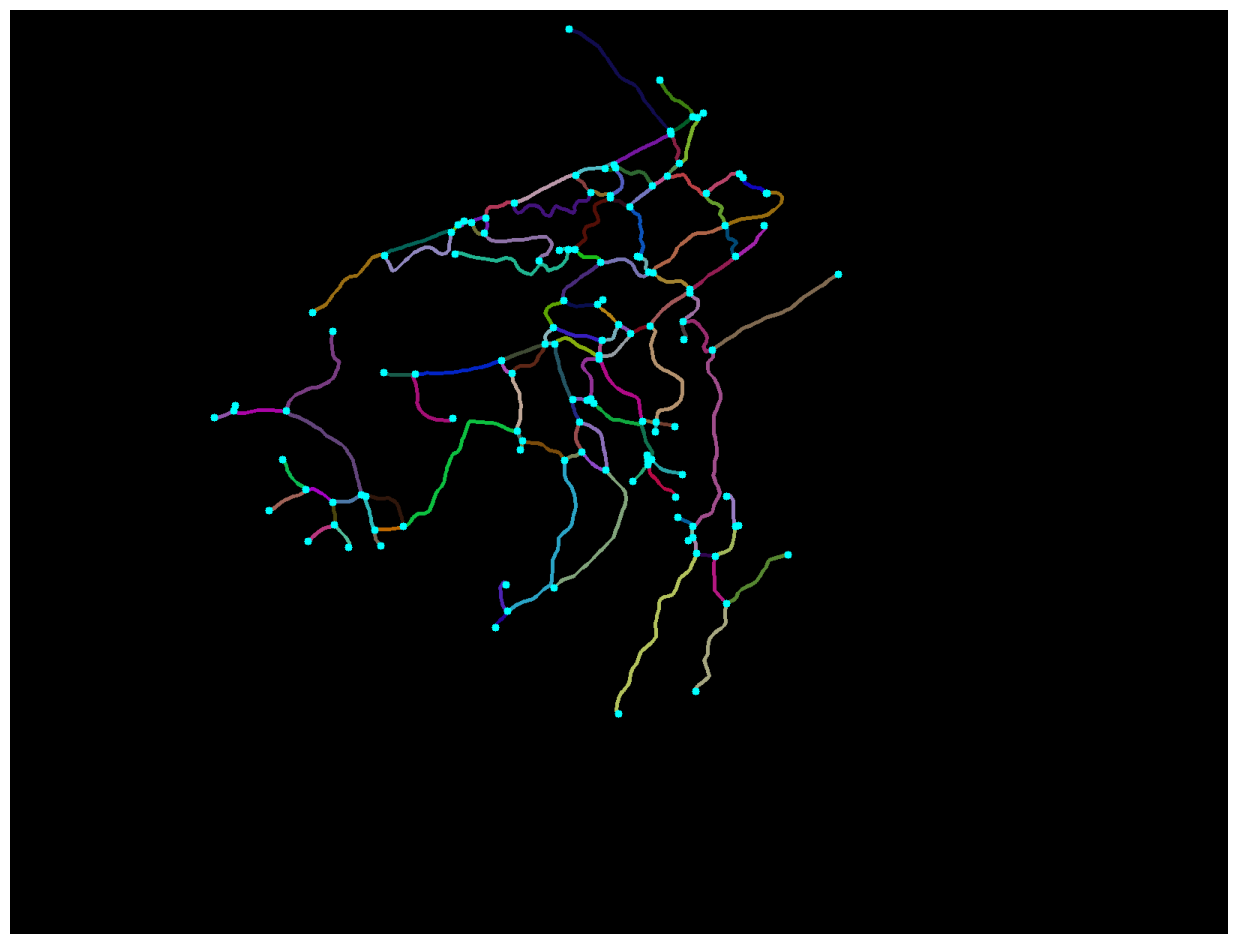

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

#Demo of Plotting Skeleton
#https://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html
im0 = imageio.imread(image_path)  #input one example image in DRIVE
black_map = np.zeros((im0.shape[0],im0.shape[1],3)).astype(np.uint8)
im = (im0[:,:]>128).astype(np.uint8)
black_map = np.zeros((im0.shape[0],im0.shape[1],3)).astype(np.uint8)
points = []
for l in polys:
  c = (200*random.random(),200*random.random(),200*random.random())
  for i in range(0,len(l)-1):
    cv2.line(im0,(l[i][0],l[i][1]),(l[i+1][0],l[i+1][1]),c,1)
    cv2.line(black_map,(l[i][0],l[i][1]),(l[i+1][0],l[i+1][1]),c,3)
      #cv2.circle(black_map,(l[i][0],l[i][1]), 1, (0,0,255), -1)
      #points.append((l[i][0],l[i][1]))
  points.append((l[len(l)-1][0],l[len(l)-1][1]))
  cv2.circle(black_map,(l[len(l)-1][0],l[len(l)-1][1]), 5, (0,255,255), -1)
  points.append((l[0][0],l[0][1]))
  cv2.circle(black_map,(l[0][0],l[0][1]), 5, (0,255,255), -1)

  #cv2.imshow('',im0);cv2.waitKey(0)
plt.figure(figsize=(16, 12))
plt.imshow(im0)
plt.axis('off')

plt.figure(figsize=(16, 12))
plt.imshow(black_map)
plt.axis('off')



/tmp/ipykernel_49084/1970644804.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im0 = imageio.imread(image_path)


(-0.5, 1623.5, 1231.5, -0.5)

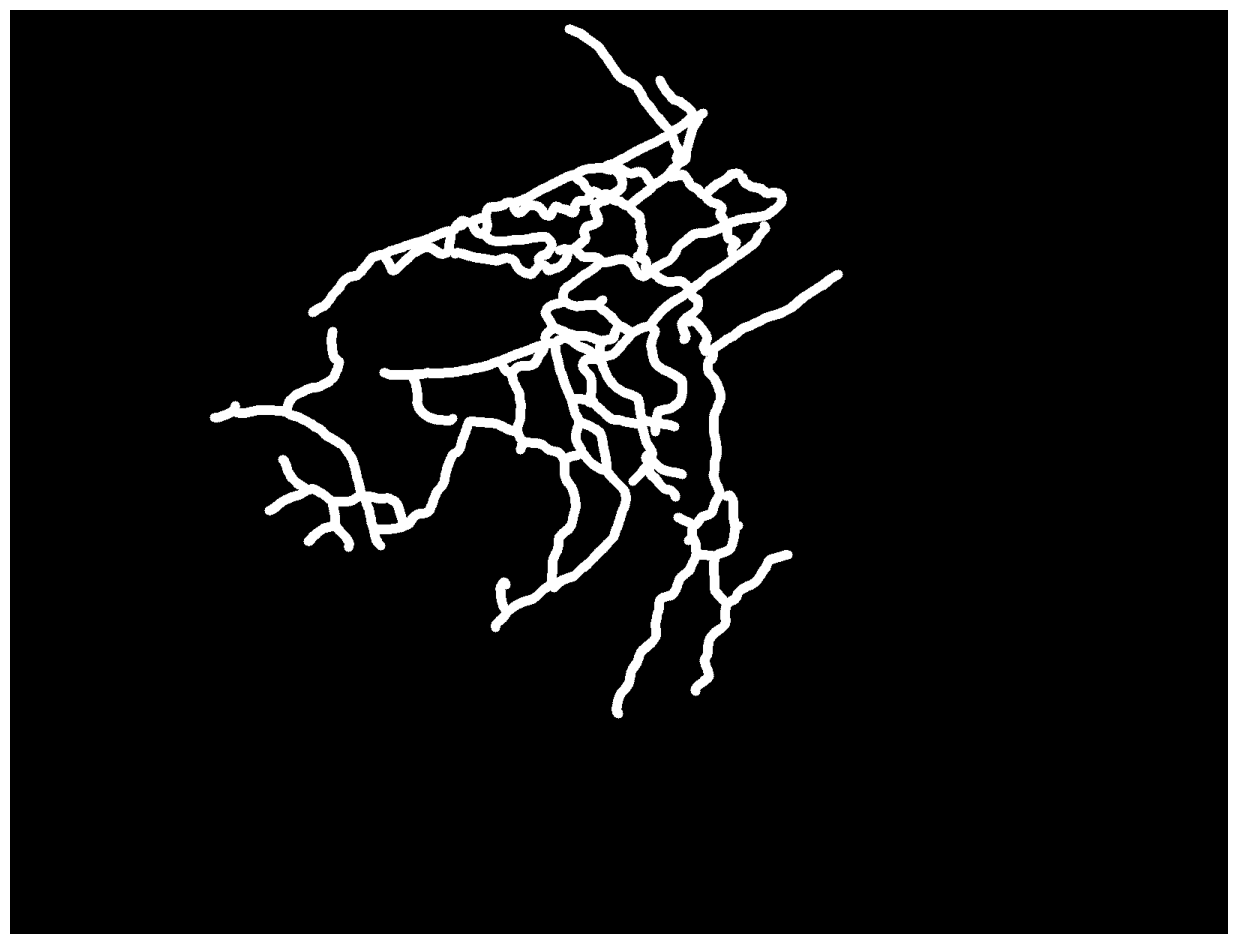

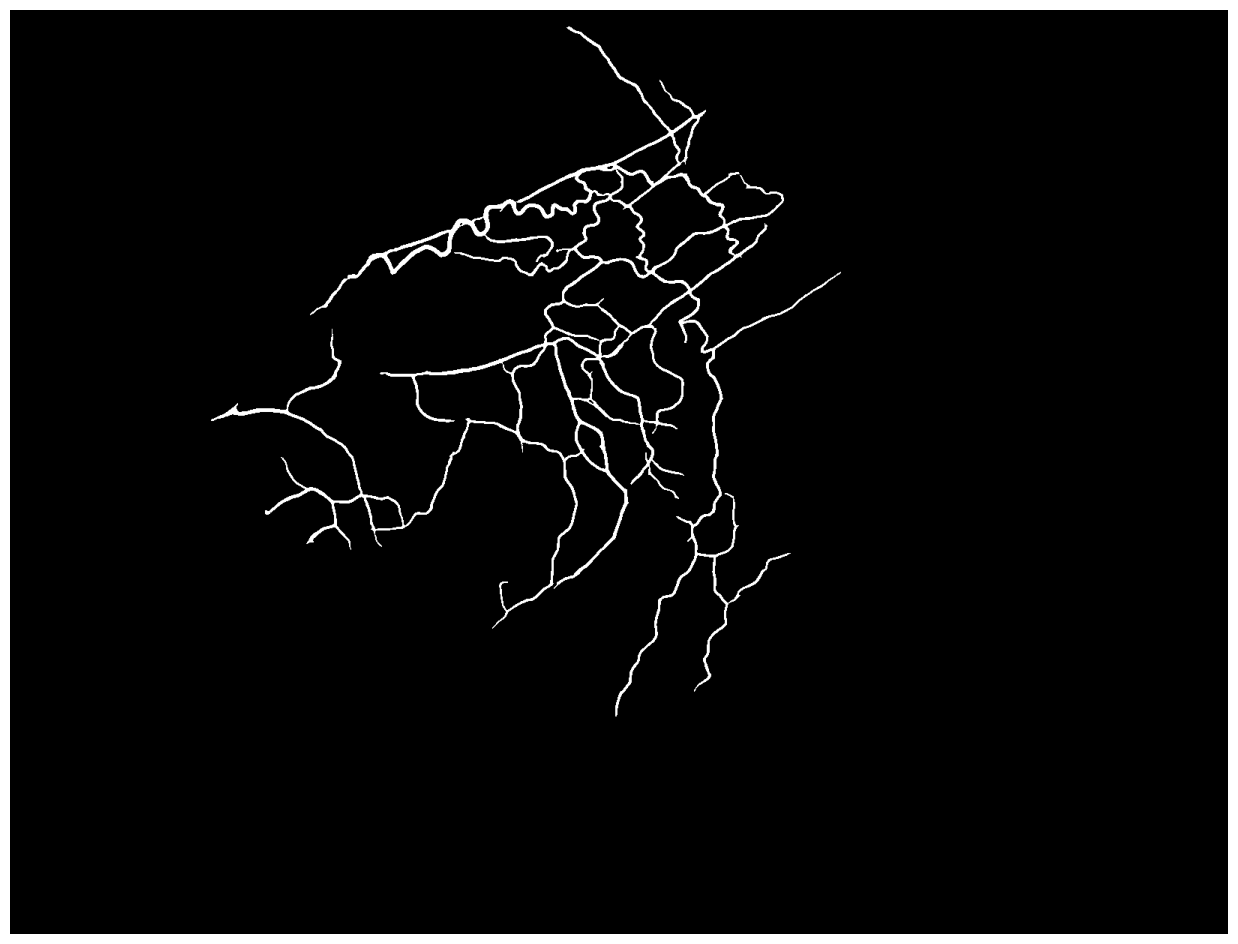

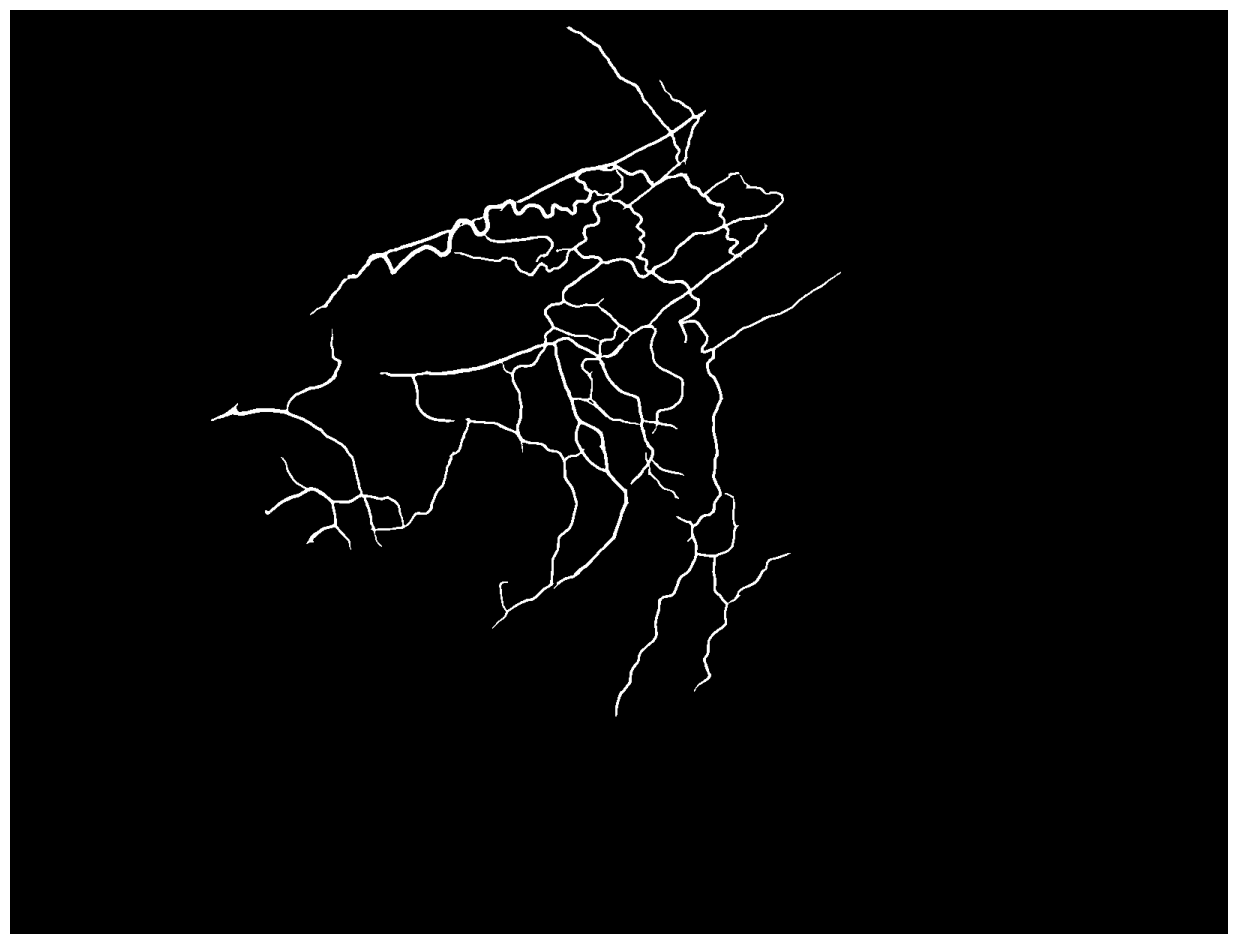

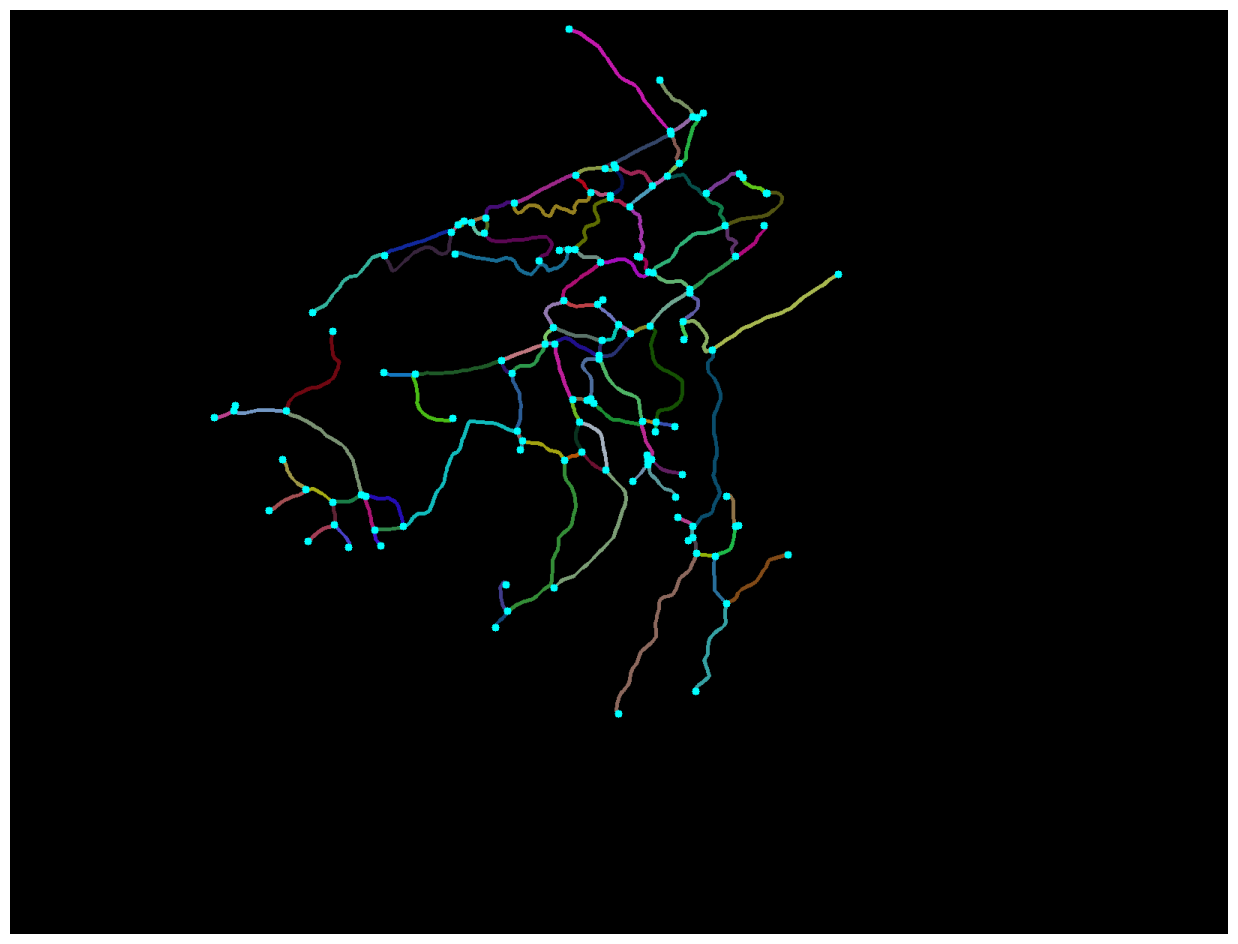

In [5]:
#random remove some segments from the ground-truth graph
#https://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html
im0 = imageio.imread(image_path) 
black_map = np.zeros((im0.shape[0],im0.shape[1],3)).astype(np.uint8)
black_mask = np.zeros((im0.shape[0],im0.shape[1],3)).astype(np.uint8)
im = (im0[:,:]>128).astype(np.uint8)
black_map = np.zeros((im0.shape[0],im0.shape[1],3)).astype(np.uint8)
points = []
for l in polys:
  if True:#np.random.rand()<0.3:
    c = (200*random.random(),200*random.random(),200*random.random())
    for i in range(0,len(l)-1):
    
      cv2.line(black_mask,(l[i][0],l[i][1]),(l[i+1][0],l[i+1][1]),[256,256,256],11)
      cv2.line(black_map,(l[i][0],l[i][1]),(l[i+1][0],l[i+1][1]),c,3)
      #cv2.circle(black_map,(l[i][0],l[i][1]), 1, (0,0,255), -1)
      #points.append((l[i][0],l[i][1]))
    points.append((l[len(l)-1][0],l[len(l)-1][1]))
    cv2.circle(black_map,(l[len(l)-1][0],l[len(l)-1][1]), 5, (0,255,255), -1)
    points.append((l[0][0],l[0][1]))
    cv2.circle(black_map,(l[0][0],l[0][1]), 5, (0,255,255), -1)

  #cv2.imshow('',im0);cv2.waitKey(0)
plt.figure(figsize=(16, 12))
plt.imshow(black_mask)
plt.axis('off')

plt.figure(figsize=(16, 12))
plt.imshow(im0, cmap='gray')
plt.axis('off')

plt.figure(figsize=(16, 12))
plt.imshow(im0 * (black_mask[:,:,0]/255.), cmap='gray')
plt.axis('off')


plt.figure(figsize=(16, 12))
plt.imshow(black_map)
plt.axis('off')


In [ ]:
# Batch Processing Methods: adding ratios
#Sort and select the vessel segments according to the thickness
#Thickness is computed by the ratio of real segment pixels and thick lines


import numpy as np
import os
import cv2
import random
import imageio
    
    
def compute_thickness(mask, real):
  roi = mask * real
  deno = np.sum(np.sum(mask/255.)) #the overall pixels
  return np.sum(np.sum(roi/255.)) / deno

def cut_vessel(im, polys, ratio=0.9, thickness=6):
  black_mask = np.zeros((im0.shape[0],im0.shape[1],3)).astype(np.uint8)
  points = []
  thick_list = []
  for ind, l in enumerate(polys):
    temp_map = np.zeros((im0.shape[0],im0.shape[1],3)).astype(np.uint8)
    for i in range(0,len(l)-1):
      cv2.line(temp_map,(l[i][0],l[i][1]),(l[i+1][0],l[i+1][1]),[255,255,255],thickness)
    thick_list.append([compute_thickness(temp_map[:,:,0], im0), ind])
        
  thick_list.sort(reverse=True) 
  sort_index = [] 
  
  for x in thick_list: 
    sort_index.append(x[1]) 
  poly_s = []

  for ind in range(len(polys)):
    poly_s.append(polys[sort_index[ind]])
  
  print(len(polys))

  #for ind in range(int(len(poly_s))):
  for ind in range(int(len(poly_s)*ratio)):
    l = poly_s[ind]
    if True:#(ind <= int(len(poly_s)*ratio)) or ( (ind > int(len(poly_s)*ratio)) and (np.random.rand() <= 0.5)):
      for i in range(0,len(l)-1):
        cv2.line(black_mask,(l[i][0],l[i][1]),(l[i+1][0],l[i+1][1]),[255,255,255],thickness)

  processed_map = im0 * (black_mask[:,:,0]/255.)
  return processed_map, poly_s

from tqdm import tqdm
if __name__ == "__main__":
  R = 0.8 #noise ratio
  TAU = 11 #thickness threshold

  poly_file = '/media/alexey/HDDDataDIsk/datasets/RetinalVesselSegmentation/CompetitionDataset/noisy_test/poly'
  os.makedirs(poly_file, exist_ok=True)
  polys_file = '/media/alexey/HDDDataDIsk/datasets/RetinalVesselSegmentation/CompetitionDataset/noisy_test/poly'+str(R)+'/'
  os.makedirs(polys_file, exist_ok=True)
  output_file = '/media/alexey/HDDDataDIsk/datasets/RetinalVesselSegmentation/CompetitionDataset/noisy_test/output_noisy_labels'+str(R)+'/'
  os.makedirs(output_file, exist_ok=True)
  import glob
  all_file = glob.glob('/home/alexey/programming/squanch_work/RetinalVesselSegmentation/third_patry/MedISeg/2DUNet/Experiment/EYEDataset_512/isic2018/baseline/res50/fold_0/test_results/submit/*.png')
  for f in tqdm(all_file):
    im0 = imageio.imread(f)
    black_map = np.zeros((im0.shape[0],im0.shape[1],3)).astype(np.uint8)
    im = (im0[:,:]>128).astype(np.uint8)
    im = thinning(im);
    rects = []
    polys = traceSkeleton(im,0,0,im.shape[1],im.shape[0],10,999,rects)
    # polys = np.load(os.path.join(poly_file, f.split('/')[-1].replace('gif', 'npy')), allow_pickle=True)
    np.save(os.path.join(poly_file, f.split('/')[-1].replace('png', 'npy')), polys)
    #Select the ratio
    cut_map, poly_s = cut_vessel(im, polys, R, TAU)
    np.save(os.path.join(polys_file, f.split('/')[-1].replace('png', 'npy')), poly_s)
    cut_map[cut_map >= 127] = 255
    cut_map[cut_map < 127] = 0
    cut_map = cv2.morphologyEx(
        cut_map, cv2.MORPH_OPEN,
        cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    )
    _, cut_map = cv2.threshold(cut_map, 127, 255, cv2.THRESH_BINARY)
    imageio.imwrite(os.path.join(output_file, f.split('/')[-1]), cut_map)
    
  

  0%|                                                               | 0/110 [00:00<?, ?it/s]/tmp/ipykernel_49084/3238708698.py:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im0 = imageio.imread(f)
/home/alexey/venv/lib/python3.8/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
  1%|▍                                                    | 1/110 [01:13<2:13:54, 73.71s/it]

93


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
  2%|▉                                                    | 2/110 [02:26<2:11:16, 72.93s/it]

1


In [ ]:
#Codes to generate the TAU value: covering the entire vessel map

from matplotlib import pyplot as plt
def reconstruct_map(im0, poly, thickness=5):
  black_mask = np.zeros((im0.shape[0],im0.shape[1],3)).astype(np.uint8)
  for ind in range(int(len(poly))):
    l = poly[ind]
    if True:
      for i in range(0,len(l)-1):
        cv2.line(black_mask,(l[i][0],l[i][1]),(l[i+1][0],l[i+1][1]),[255,255,255],thickness)

  processed_map = im0 * (black_mask[:,:,0]/255.)
  return processed_map
  

def find_optimal_thick():
  poly_file = '../dataset/DRIVE_noisy/training/poly_label/'
  import glob
  all_file = glob.glob('../dataset/DRIVE/VE/*.gif')
  error_trend = []
  for r in range(1,20):
    error = 0
    for ind, f in enumerate(all_file):
      im0 = imageio.imread(f)
      polys = np.load(os.path.join(poly_file, f.split('/')[-1].replace('gif', 'npy')), allow_pickle=True)
      rec = reconstruct_map(im0, polys, r)
      error += np.mean(im0/255. - rec/255.)
      if ind == 0:
        plt.figure(figsize=(16, 12))
        plt.imshow(im0 - rec)
        plt.axis('off')

    error /= 20.
    print(error)
    error_trend.append(error)
  return error_trend
    
error_trend = find_optimal_thick()



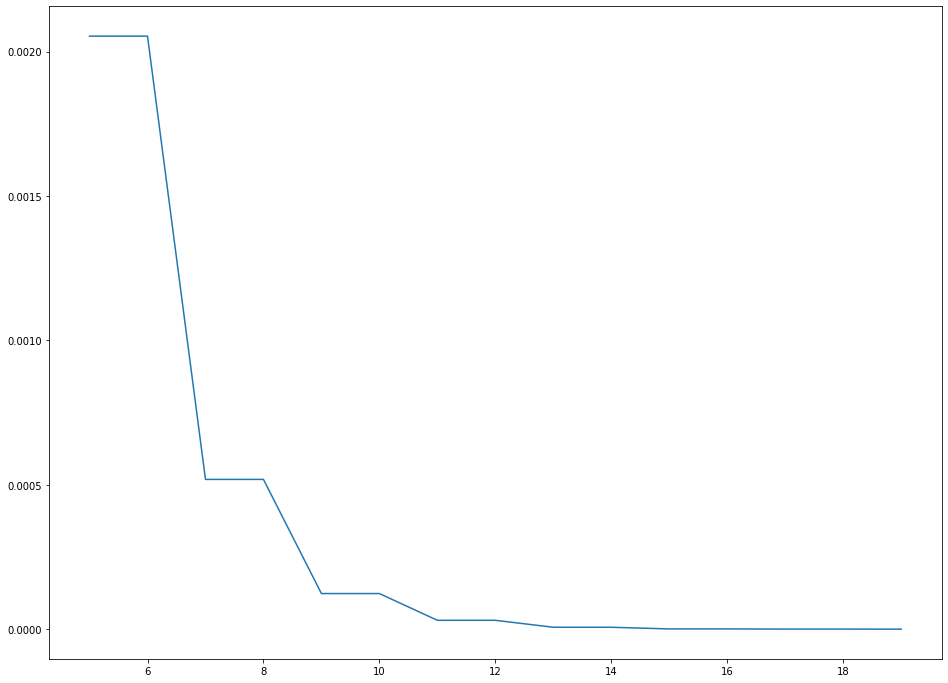

In [38]:
plt.figure(figsize=(16, 12))
plt.ylim([0,0.003])
plt.plot(range(5,20), error_trend)